# Logistic regression with COSMO

_The presented example is adapted from the [Machine Learning - course by Andrew Ng](https://www.coursera.org/learn/machine-learning)._

In this example we use logistic regression to estimate the parameters $\theta_i$ of a logistic model in a classification problem. We will first transform the logistic regression problem into an exponential cone optimisation problem. We will then solve the optimisation problem with COSMO and determine the model parameters and the decision boundary.

### Visualizing the data

Before we start, let's load and take a look at the example data from `examples/chip_data.txt`:

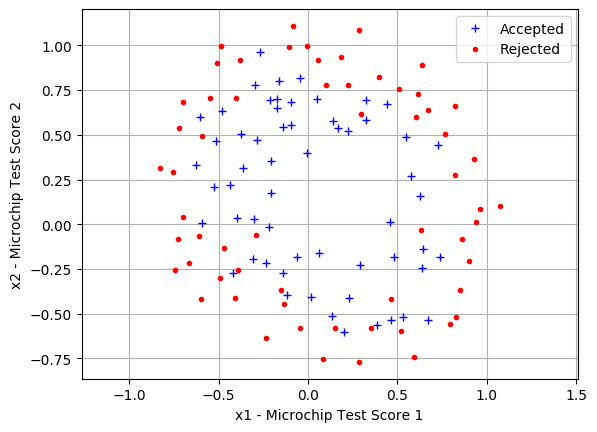

In [20]:
using PyCall, LinearAlgebra, SparseArrays, COSMO, JuMP
pygui(:qt5)
using PyPlot

# load example data
f = open("./chip_data.txt")
lines = readlines(f)
close(f)
n_data = length(lines)
x1 = zeros(n_data)
x2 = zeros(n_data)
y = zeros(Float64, n_data)
for (i, l) in enumerate(lines)
    s = split(l, ",")
    x1[i] = parse(Float64, s[1])
    x2[i] = parse(Float64, s[2])
    y[i] = parse(Float64, s[3])
end


# visualize data
PyPlot.figure(1)
p1 = plot(x1[findall(x -> x == 1., y)], x2[findall(x -> x == 1., y)], marker = "+", color = "b", linestyle= "None", label="Accepted")
p2 = plot(x1[findall(x -> x != 1., y)], x2[findall(x -> x != 1., y)], marker = ".", color = "r", linestyle= "None", label="Rejected")
axis("equal")
PyPlot.grid(true)
PyPlot.legend()
xlabel("x1 - Microchip Test Score 1")
ylabel("x2 - Microchip Test Score 2")
nothing

The plot shows two test scores of $n$ microchip samples from a fabrication plant and whether the chip passed the quality check. Based on this data we would like to build a logistic model that takes into account the test scores and helps us predict the likelyhood of a chip being accepted.

### Defining the logistic model

The logistic regression hypothesis is given by 

\begin{equation}
h_\theta(x) = g(\theta^\top x)
\end{equation}

where $g$ is the sigmoid function:

\begin{equation}
g(\theta^\top x) = \frac{1}{1+\exp(-\theta^\top x)}.
\end{equation}

$x$ are the independent variables and $\theta$ are the model parameters. For our samples we set the dependent variable $y =1$ if the chip was accepted and $y = 0$ otherwise.

$h_\theta(x)$ can be interpreted as the probability of the outcome being true rather than false. We want to find the parameters $\theta$ such that the following likelyhood function is maximized:

\begin{equation}
\text{maximize} \quad J(\theta) = h_\theta(x_i)^{y_i} (1-h_\theta(x_i))^{(1-y_i)} + \mu \|\theta \|_2,
\end{equation}

where we added a regularization term with parameter $\mu$ to prevent overfitting. 

### Feature mapping
As our dataset only has two independent variables (the test scores) our model $y = \theta_0 + \theta_1 x_1 + \theta_2 x_2$ will have the form of a straight line. Looking at the plot one can see that a line will not perform well in separating the samples. Therefore, we will create more features based on each data point by mapping the original features ($x_1$, $x_2$) into all polynomial terms of $x_1$ and $x_2$ up to the 6th power:

\begin{equation}
\text{map_feature}(x_1,x_2) = [1, x_1, x_2, x_1^2, x_1x_2, x_2^2, x_1^3, \dots, x_1x_2^5, x_2^6 ]
\end{equation}

This will create 28 features for each sample.



In [21]:
function map_feature(x1, x2)
  deg = 6
  x_new = ones(length(x1))
  for i = 1:deg, j = 0:i
      x_new = hcat(x_new, x1.^(i-j) .* x2.^j)
  end
  return x_new
end

X = map_feature(x1, x2);
size(X)

(118, 28)

### Transformation into a conic optimisation problem
We can rewrite above likelyhood maximisation problem as a conic optimisation problem with exponential-cone-, second-order-cone-, equality-, and inequality constraints:

\begin{equation} 
\begin{array}{ll}
\text{minimize}  &\sum_i^n \epsilon_i + \mu v\\
\text{subject to}  & \|\theta \|_2 \leq v\\
&  \log(1 + \exp(-\theta^\top x_i)) \leq \epsilon_i  \quad \text{if } y_i = 1, \\ 
& \log(1 + \exp(\theta^\top x_i)) \leq \epsilon_i  \quad\text{   otherwise.}
\end{array}
\end{equation} 

Implementing the constraint $\log(1 + \exp(z)) \leq \epsilon $ for each of the $n$ samples requires two exponential cone constraints, one inequality constraint and two equality constraints. To see this, take the exponential on both sides and then divide by $\exp(\epsilon)$ to get:

\begin{equation}
\exp(-\epsilon) + \exp(z - \epsilon) \leq 1.
\end{equation}

This constraint is equivalent to:

\begin{equation} 
\begin{array}{ll}
(z - \epsilon, s_1, t_1) &\in K_{\text{exp}}, \\
(-\epsilon, s_2, t_2) &\in K_{\text{exp}}, \\
t_1 + t_2 &\leq 1,\\
s_1 = s_2 &= 1,
\end{array}
\end{equation}

where we defined the exponential cone as:

\begin{equation}
K_{\text{exp}} = \{(r, s, t) \mid s >0, s \exp(r/s) \leq t \} \cup \{ r \leq 0, s = 0, t \geq 0 \}.
\end{equation}

Based on this transformation our optimisation problem will have $5n + n_\theta + 1$ variables, 1 SOCP constraint, $2n$ exponential cone constraints, $n$ inequality constraints and $2n$ equality constraints.
Let's model the problem with JuMP and COSMO:

In [22]:
n_theta = size(X, 2)
n = n_data
μ  = 1.

m = Model(with_optimizer(COSMO.Optimizer))
@variable(m, v)
@variable(m, θ[1:n_theta])
@variable(m, e[1:n])
@variable(m, t1[1:n])
@variable(m, t2[1:n])
@variable(m, s1[1:n])
@variable(m, s2[1:n])

@objective(m, Min, μ * v + sum(e))
@constraint(m, [v; θ] in MOI.SecondOrderCone(n_theta + 1))

# create the constraints for each sample points
for i = 1:n
  yi = y[i]
  x = X[i, :]
  yi == 1. ? (a = -1) : (a = 1)
  @constraint(m, [a * dot(θ, x) - e[i]; s1[i]; t1[i] ] in MOI.ExponentialCone())
  @constraint(m, [-e[i]; s2[i]; t2[i]] in MOI.ExponentialCone())
  @constraint(m, t1[i] + t2[i] <= 1)
  @constraint(m, s1[i] == 1)
  @constraint(m, s2[i] == 1)
end
JuMP.optimize!(m)
theta = value.(θ)


------------------------------------------------------------------
             COSMO - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2019
------------------------------------------------------------------

Problem:  x ∈ R^{619},
          constraints: A ∈ R^{1091x619} (4513 nnz), b ∈ R^{1091},
          matrix size to factor: 1710x1710 (2924100 elem, 10736 nnz)
Sets:     ZeroSet{Float64} of dim: 236
          Nonnegatives{Float64} of dim: 118
          SecondOrderCone{Float64} of dim: 29
          ExponentialCone{Float64} of dim: 3
          ExponentialCone{Float64} of dim: 3
          ExponentialCone{Float64} of dim: 3
          ... and 234 more
Settings: ϵ_abs = 1.0e-04, ϵ_rel = 1.0e-04,
          ϵ_prim_inf = 1.0e-06, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1.0e-6, α = 1.6,
          max_iter = 2500,
          scaling iter = 10 (on),
          check termination every 40 iter,
          check infeasibili

28-element Array{Float64,1}:
  2.674439930406765  
  1.7748860393946884 
  2.934236553994507  
 -4.053008143592888  
 -3.3811679943697612 
 -4.0530397674103735 
  0.7775813452248421 
 -1.0919224676820907 
 -0.46310226688930994
 -0.48894009682277273
 -3.2952703524511726 
  0.5638302900174557 
 -1.8175402706656334 
  ⋮                  
 -0.47307150885083393
  0.6345032449500374 
 -1.1631145722989464 
 -1.2247379129099638 
 -0.09277151198530442
 -2.685527206587255  
  0.4665466584002503 
 -0.7660832134314224 
  0.44944903637367295
 -1.190858736040457  
 -0.9542098066640803 
 -1.1918683708910005 

Once we have solved the optimisation problem and obtained the parameter vector $\theta$, we can plot the decision boundary. This can be done by evaluating our model over a grid of points $(u,v)$ and then plotting the contour line where the function returns a probability of $p=0.5$.

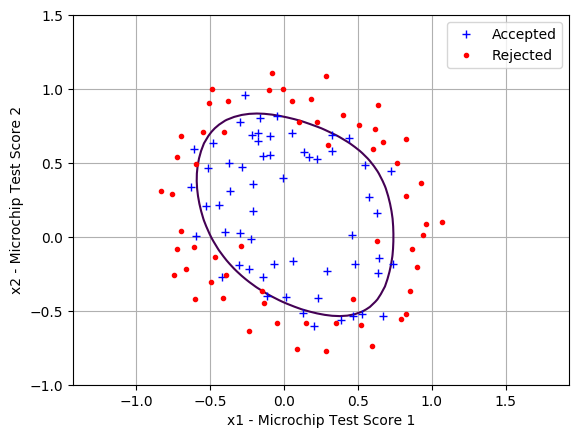

In [23]:
# First we evaluate our model over a grid of points z = Model(u, v)
u = collect(range(-1., stop = 1.5, length = 50))
v = collect(range(-1., stop = 1.5, length = 50))
z = zeros(length(u), length(v));
for i = 1:length(u), j = 1:length(v)
    z[i, j] = dot(map_feature(u[i], v[j]), theta);
end


# visualize data with decision boundary
PyPlot.figure(2)
p1 = plot(x1[findall(x -> x == 1., y)], x2[findall(x -> x == 1., y)], marker = "+", color = "b", linestyle= "None", label="Accepted")
p2 = plot(x1[findall(x -> x != 1., y)], x2[findall(x -> x != 1., y)], marker = ".", color = "r", linestyle= "None", label="Rejected")
axis("equal")
PyPlot.grid(true)
PyPlot.legend()
xlabel("x1 - Microchip Test Score 1")
ylabel("x2 - Microchip Test Score 2")
# Now add the decision boundary as a contour plot
contour(u, v, z', [0.5])
nothing

## Solving the optimisation problem directly with COSMO
We can solve the problem directly in COSMO by using its modeling interface. The problem will have $nn = 5 n + n_\theta + 1$ variables. Let us define the cost function  $ \frac{1}{2}x^\top P x + q^\top x $:

In [24]:
nn = 5 * n + n_theta +  1
P = spzeros(nn, nn)
q = zeros(nn)
q[1] = μ
for i = 1:n
  q[1 + n_theta + (i - 1) * 5 + 1] = 1.
end

Next we define a function that creates the `COSMO.Constraints` for a given sample: 

In [25]:
# the order of the variables
# v, thetas, [e1 t11 t12 s11 s12] [e2 t21 t22 s21 s22] ...
# for each sample create two exponential cone constraints, 
# 1 nonnegatives constraint, 2 zeroset constraints
function add_log_regression_constraints!(constraint_list, x, y, n, sample_num)
  num_thetas = length(x)
  # 1st exponential cone constraint (zi - ei, s1, t1) in Kexp
  c_start = 1 + num_thetas + (sample_num - 1) * 5 + 1
  A = spzeros(3, n)
  A[1, c_start] = -1.
  y == 1. ? (a = -1) : (a = 1)
  for k = 1:num_thetas
    A[1, 2 + k - 1] = a * x[k]
  end
  A[2, c_start + 3] = 1.
  A[3, c_start + 1] = 1.
  b = zeros(3)
  push!(constraint_list, COSMO.Constraint(A, b, COSMO.ExponentialCone))

  # 2nd exponential cone constraint (-e, s2, t2)
  A = spzeros(3, n)
  A[1, c_start] = -1.
  A[2, c_start + 4] = 1.
  A[3, c_start + 2] = 1.
  b = zeros(3)
  push!(constraint_list, COSMO.Constraint(A, b, COSMO.ExponentialCone))

  # Nonnegatives constraint t1 + t2 <= 1
  A = spzeros(1, n)
  A[1, c_start + 1] = -1.
  A[1, c_start + 2] = -1.
  b = [1.]
  push!(constraint_list, COSMO.Constraint(A, b, COSMO.Nonnegatives))

  # ZeroSet constraint s1 == 1, s2 == 1
  A = spzeros(2, n)
  A[1, c_start + 3] = 1.
  A[2, c_start + 4] = 1.
  b = -1 * ones(2)
  push!(constraint_list, COSMO.Constraint(A, b, COSMO.ZeroSet))
end

add_log_regression_constraints! (generic function with 1 method)

Now we can use this function to loop over the sample points and add the constraints to our constraint list:

In [26]:
constraint_list = Array{COSMO.Constraint{Float64}}(undef, 0)
for i = 1:n
  add_log_regression_constraints!(constraint_list, X[i, :], y[i], nn, i )
end

It remains to add a second order cone constraint for the regularisation term:

$\|\theta \|_2 \leq v$

In [27]:
push!(constraint_list, COSMO.Constraint(Matrix(1.0I, n_theta + 1, n_theta + 1), zeros(n_theta + 1), COSMO.SecondOrderCone, nn, 1:n_theta+1))
nothing

We can now create, assemble, and solve our `COSMO.Model`:

In [28]:
model = COSMO.Model()
assemble!(model, P, q, constraint_list, settings = COSMO.Settings(verbose=true))
res = COSMO.optimize!(model);

------------------------------------------------------------------
             COSMO - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2019
------------------------------------------------------------------

Problem:  x ∈ R^{619},
          constraints: A ∈ R^{1091x619} (4513 nnz), b ∈ R^{1091},
          matrix size to factor: 1710x1710 (2924100 elem, 10736 nnz)
Sets:     ZeroSet{Float64} of dim: 236
          Nonnegatives{Float64} of dim: 118
          SecondOrderCone{Float64} of dim: 29
          ExponentialCone{Float64} of dim: 3
          ExponentialCone{Float64} of dim: 3
          ExponentialCone{Float64} of dim: 3
          ... and 234 more
Settings: ϵ_abs = 1.0e-04, ϵ_rel = 1.0e-04,
          ϵ_prim_inf = 1.0e-06, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1.0e-6, α = 1.6,
          max_iter = 2500,
          scaling iter = 10 (on),
          check termination every 40 iter,
          check infeasibili

Let us double check that we get the same $\theta$ as in the previous section:

In [29]:
using Test
theta_cosmo = res.x[2:2+n_theta-1]
@test norm(theta_cosmo - theta) < 1e-10

Test Passed